In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from os import path

from tqdm import tqdm
import torch
from omegaconf import OmegaConf, open_dict

from experanto.datasets import ChunkDataset
from experanto.dataloaders import get_multisession_dataloader

#### Load Config Object from .yaml file

In [3]:
from experanto.configs import DEFAULT_CONFIG as cfg

print(OmegaConf.to_yaml(cfg))

dataset:
  global_sampling_rate: null
  global_chunk_size: null
  modality_config:
    screen:
      sampling_rate: null
      chunk_size: null
      valid_condition:
        tier: train
      offset: 0
      sample_stride: 4
      include_blanks: true
      transforms:
        Normalize:
          _target_: torchvision.transforms.v2.Normalize
          mean:
          - 80.0
          std:
          - 60.0
        Resize:
          _target_: torchvision.transforms.v2.Resize
          size:
          - 144
          - 256
      interpolation:
        rescale: true
        rescale_size:
        - 144
        - 256
    responses:
      sampling_rate: null
      chunk_size: null
      offset: 0.1
      transforms:
        standardize: true
      interpolation:
        interpolation_mode: nearest_neighbor
    eye_tracker:
      sampling_rate: null
      chunk_size: null
      offset: 0
      transforms:
        normalize: true
      interpolation:
        interpolation_mode: nearest_neighb

#### Modify the config

In [1]:
cfg.dataset.modality_config.screen.include_blanks = True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

NameError: name 'cfg' is not defined

#### Instantiate dataloader

In [ ]:
paths = [
    "dynamic29513-3-5-Video-full",
    "dynamic29514-2-9-Video-full",
    "dynamic29755-2-8-Video-full",
    "dynamic29647-19-8-Video-full",
    "dynamic29156-11-10-Video-full",
    "dynamic29623-4-9-Video-full",
    "dynamic29515-10-12-Video-full",
    "dynamic29234-6-9-Video-full",
    "dynamic29712-5-9-Video-full",
    "dynamic29228-2-10-Video-full",
]

## add full path
full_paths = [path.join("/data/", f) for f in paths]

In [5]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths, cfg)

In [6]:
keys = []
for i, (k, b) in tqdm(enumerate(train_dl)):
    keys.append(k)  # to show in which sequences the data_keys get drawn
    _ = b["screen"].to("cuda", torch.bfloat16, non_blocking=True)
    _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
    _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
    if i > 200:
        break

201it [00:13, 15.37it/s]


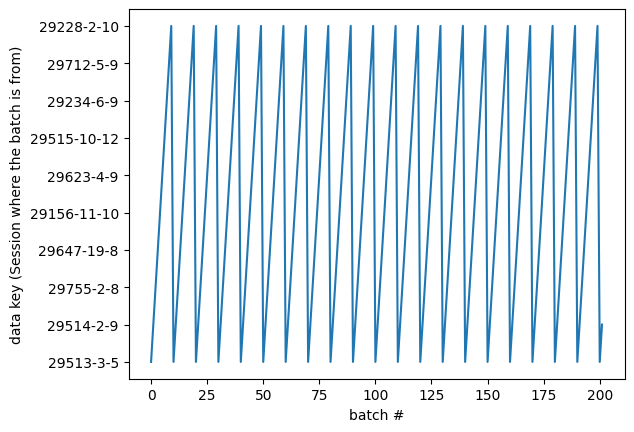

In [7]:
plt.plot(keys)
plt.xlabel("batch #")
plt.ylabel("data key (Session where the batch is from)");

# A look inside the Dataset Object

In [8]:
from experanto.configs import DEFAULT_CONFIG as cfg

In [9]:
root_folder = paths[0]

# most relevant configs:
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8

cfg.dataset.modality_config.screen.include_blanks = True
cfg.dataset.modality_config.screen.valid_condition = {
    "tier": "train"
}  # only returns train
# can also be combined with any other meta data entry
# cfg.dataset.modality_config.screen.valid_condition = {"tier": "test", "stim_type": "stimulus.Clip"}

cfg.dataset.modality_config.screen.sample_stride = 4  #
# determines len(Dataset) = (n_samples / sample_stride)
# the default before was sample_stride=chunk_size
# but the smaller the stride, the more diverese the dataset gets

In [10]:
dataset = ChunkDataset(full_paths[0], **cfg.dataset)

responses torch.Size([16, 7671])
screen torch.Size([16, 1, 144, 256])
eye_tracker torch.Size([16, 4])
treadmill torch.Size([16, 1])
timestamps torch.Size([16, 7671])


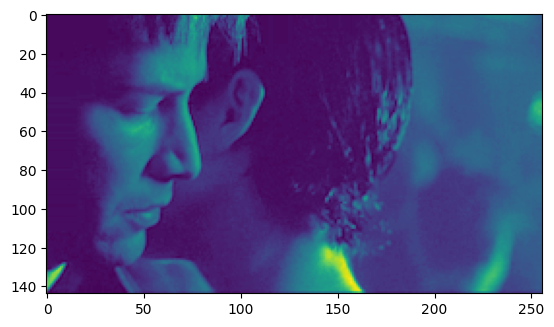

In [11]:
datapoint = dataset[12]
for k, v in datapoint.items():
    print(k, v.shape)
plt.imshow(datapoint["screen"][1, 0])

In [12]:
len(dataset)
# corresponds to len(dataset._full_valid_sample_times) // (dataset.sample_stride)

6486

In [13]:
len(dataset._full_valid_sample_times)
# all these samples are valid, meaning that they
# - have the right tier, or condition, or both
# - when used as a starting index, the full chunk size is valid
# - doesnt extend past the end of the experiment

25943

## custom transforms

In [14]:
# transforms
dataset.transforms["screen"]

Compose(
      Lambda(<lambda>, types=['object'])
      Normalize(mean=[80.0], std=[60.0], inplace=False)
      Resize(size=[144, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
)

In [15]:
cfg.dataset.modality_config.screen.transforms

{'Normalize': {'_target_': 'torchvision.transforms.v2.Normalize', 'mean': [80.0], 'std': [60.0]}, 'Resize': {'_target_': 'torchvision.transforms.v2.Resize', 'size': [144, 256]}}

In [16]:
root_folder = paths[0]

# add a CenterCrop transform
with open_dict(cfg):
    cfg.dataset.modality_config.screen.transforms.CenterCrop = {
        "_target_": "torchvision.transforms.v2.CenterCrop",
        "size": 144,
    }
# most relevant configs:
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8

cfg.dataset.modality_config.screen.include_blanks = False
cfg.dataset.modality_config.screen.valid_condition = {
    "stim_type": "stimulus.DotSequence"
}
# can also be combined with any other meta data entry
# cfg.dataset.modality_config.screen.valid_condition = {"tier": "test", "stim_type": "stimulus.Clip"}

cfg.dataset.modality_config.screen.sample_stride = 4  #
# determines len(Dataset) = (n_samples / sample_stride)
# the default before was sample_stride=chunk_size
# but the smaller the stride, the more diverese the dataset gets

In [17]:
dataset = ChunkDataset(full_paths[0], **cfg.dataset)
dataset.meta_conditions["stim_type"][:10]  # first 10 trials

['stimulus.Clip',
 'stimulus.Clip',
 'stimulus.DotSequence',
 'stimulus.Clip',
 'blank',
 'stimulus.Frame',
 'blank',
 'blank',
 'stimulus.Frame',
 'blank']

responses torch.Size([16, 7671])
screen torch.Size([16, 1, 144, 144])
eye_tracker torch.Size([16, 4])
treadmill torch.Size([16, 1])
timestamps torch.Size([16, 7671])


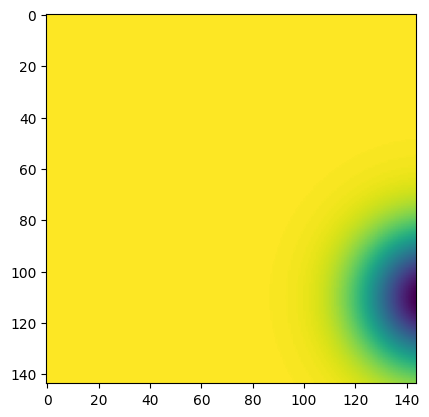

In [18]:
datapoint = dataset[1]
for k, v in datapoint.items():
    print(k, v.shape)

plt.imshow(datapoint["screen"][1, 0])
# image has the new 144, 144 shape